# VES Results

In [1]:
import glob
import json

import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy.special import digamma
from scipy.spatial.distance import pdist, squareform

In [2]:
%load_ext cython

## Two Different Methods to Quantify Exploration-Exploitation

### Total Center Distance

Following the work of [Local Bayesian Optimization](https://proceedings.neurips.cc/paper_files/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf), we use the accumulative observation center movements at each step $t$ to measure how the optimization process prefers exploration over exploitation. We use $\sum_{i=1}^t\boldsymbol{x}_i/t=:\bar{\boldsymbol{x}}_t\in\mathbb{R}^D$ the geometric center of all the observation points, then the Total Center Distance (TCD) at step $t$ is

$$\text{TCD}(t):= \sum_{i=1}^t \lVert \bar{\boldsymbol{x}}_i - \bar{\boldsymbol{x}}_{i-1}\rVert,\quad \bar{\boldsymbol{x}}_0 = \boldsymbol{0}.$$

TCD is robust and easy to compute, no matter how high the problem dimension is. However, when the problem shows multi-modal property, it is unclear whether the values of TCD align with the exploration-biasness. 

### (Updated) Observational Traveling Salesman Distance (OTSP)

We updated TCD result and replaced with the traveling salesman distance (TSD) among the first $t$ observation points. The values are solved through greedy algorithm:

$$\text{OTSD}(t) := \text{TSD}(\{\boldsymbol{x}_i\}_{i=1}^t).$$

### Observation Entropy

Inspired from the idea in the [measure of spread work](https://proceedings.mlr.press/v202/marbut23a/marbut23a.pdf), we consider using the information entropy of the observation points at step $t$ to describe how uniformly the observation points are distributed. A large value suggests a stronger bias for exploration, while smaller values imply higher exploitation. Given a set of observations $\{\boldsymbol{x}_i\}_{i=1}^t$ at the step $t$, the formulation is

$$H(t) := \frac{1}{t}\sum_{i=1}^t -\log_2 p(\boldsymbol{x}_i),$$

where the density function $p(\boldsymbol{x})$ represents the observation density at the current position $\boldsymbol{x}$, which can be derived through K nearest neighbors; see details in [Kozachenko–Leonenko
entropy estimator](https://arxiv.org/pdf/1602.07440). Although such way to quantify exploration effectively avoid the multi-modality concern, it heavily gets cursed by dimensionality as a non-parametric method. Due to the singularity issue, we are only able to show $H(t)$ when $t \geq D$.

In [3]:
%%cython

import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy.special import digamma
from scipy.spatial.distance import pdist, squareform

def knn_entropy(X, k=3):
    """
    Estimate the Shannon entropy of a dataset using the k-ncpdef earest neighbors method.


    Parameters:
        X (numpy.ndarray): The N x D array of data points.
        k (int): Number of neighbors to use in the k-NN estimation.
        
    Returns:
        float: The estimated entropy.
    """
    N, D = X.shape
    tree = cKDTree(X)
    distances, _ = tree.query(X, k + 1)  # k+1 because the point itself is included in neighbors
    nn_distances = distances[:, -1]  # k-th nearest neighbor distance
    avg_log_dist = np.mean(np.log(nn_distances + 1e-10))  # Add small value to avoid log(0)
    
    # Calculate the entropy
    entropy_estimate = (
        digamma(N) - digamma(k) + D * np.log(2) + D * avg_log_dist
    )
    return entropy_estimate

def exploration_entropy(X):
    """
    Calculate the empirical Shannon entropy over cumulative observation points at each time step,
    dynamically setting k based on the sample size.
    
    Parameters:
        X (numpy.ndarray): The T x D array where each row is a data point in [0, 1]^D.
    
    Returns:
        numpy.ndarray: An array of entropy values for each time step.
    """
    T, D = X.shape
    entropies = np.zeros(T)
    cumulative_data = []

    for t in range(T):
        # Append the current data point to the cumulative list
        cumulative_data.append(X[t])
        cumulative_array = np.array(cumulative_data)

        # Dynamically set k as the square root of current sample size
        k = max(3, int(np.sqrt(t + 1)))  # Minimum k of 3 for stability

        # Estimate entropy using k-NN on cumulative data
        entropies[t] = knn_entropy(cumulative_array, k=k)

    return entropies[D:] # Due to singularity, the first D points are ignored

def exploration_center_movement(X):
    """
    Movement of observation center over time.
    Args:
        X (np.ndarray): shape (T, D)
    Returns:
        Z (np.ndarray): shape (T, 1)
    """
    T, D = X.shape
    prev_center = np.zeros(D)
    accu_movement = np.zeros(shape=(T, 1))
    for t in range(T):
        x = X[t]
        accu_movement[t, 0] += np.linalg.norm(x - prev_center)
        prev_center = x
    return np.cumsum(accu_movement, axis=0)



In [5]:
%%cython
import scipy
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.double_t, ndim=2] exploration_tsp(np.ndarray[np.double_t, ndim=2] X): 
    """
    Movement of observation center over time.
    Args:
        X (np.ndarray): shape (T, D)
    Returns:
        Z (np.ndarray): shape (T, 1)
    """
    #T, D = X.shape
    cdef int T = X.shape[0]
    cdef int D = X.shape[1]
    cdef np.ndarray[np.double_t, ndim=2] tsp_solution = np.zeros(shape=(T, 1))
    
    # Initialize with the first point's TSP solution
    current_path  = [0, 0]
    cdef float cumulative_distance = 0.0
    tsp_solution[0, 0] = cumulative_distance

    cdef float best_distance_increase
    cdef float dist_increase
    cdef int best_insertion_index
    cdef np.ndarray[np.double_t, ndim=2] dist_matrix
    
    # Calculate distances incrementally
    for t in range(1, T):
        # Update path by finding the best place to insert the new point
        best_distance_increase = float('inf')
        best_insertion_index = -1
        dist_matrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X[:t+1]))  # Update distance matrix to include the new point
        
        # Try inserting the new point in each position in the current path
        for i in range(len(current_path) - 1):
            # Calculate distance if new point were inserted between path[i] and path[i+1]
            dist_increase = (dist_matrix[current_path[i], t] +
                             dist_matrix[t, current_path[i+1]] -
                             dist_matrix[current_path[i], current_path[i+1]])
            if dist_increase < best_distance_increase:
                best_distance_increase = dist_increase
                best_insertion_index = i + 1
        
        # Insert the new point at the best position found
        if best_insertion_index != -1:
            current_path.insert(best_insertion_index, t)
        cumulative_distance += best_distance_increase
        tsp_solution[t, 0] = cumulative_distance
    
    return tsp_solution


## Table of Contents

- [Prior Samples](#prior-samples)
- [Test Functions](#test-functions)
- [Real-world Benchmarks](#real-world-benchmarks)


## VES-Gamma Performance compared with EI and MES

### Prior Samples

#### Learned Lengthscale (MAP)

In [6]:
benchmarks = ['branin2', 'hartmann6', 'rover', 'mopta08',
              'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2',
              'prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2',
              'prior_sample_100d_ls0.5', 'prior_sample_100d_ls1', 'prior_sample_100d_ls2',
              'levy300', 'levy500', 'schwefel300', 'schwefel500', 'griewank300', 'griewank500', 'lasso-high',
              'lasso-hard', 'lasso-dna', 'svm']
run_dirs_ves = glob.glob('../results/rerun_ves_nov_22_w_noise/*')
run_dirs_ei = glob.glob('../results/rerun_ei_nov_22_w_noise/*')
run_dirs_mes = glob.glob('../results/rerun_mes_dec_1_w_noise/*')

run_dirs = run_dirs_ves + run_dirs_ei + run_dirs_mes

branin2


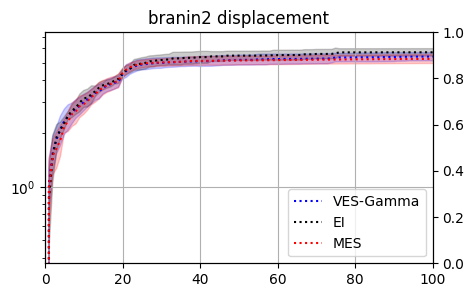

hartmann6


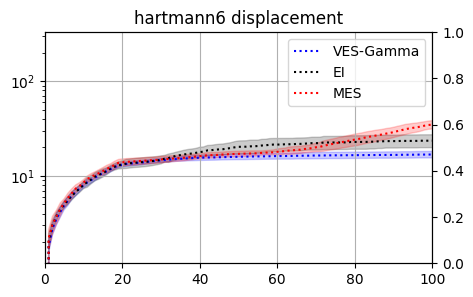

rover


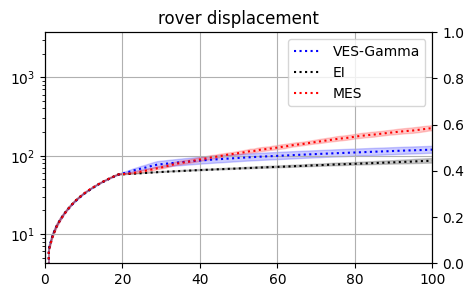

mopta08


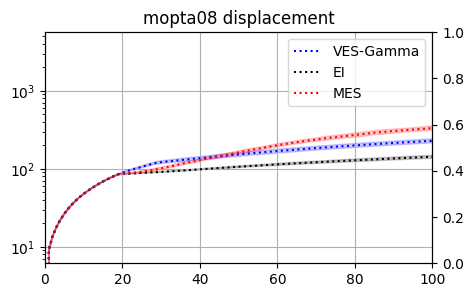

prior_sample_2d_ls0.5


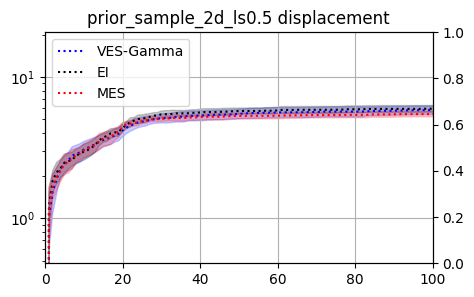

prior_sample_2d_ls1


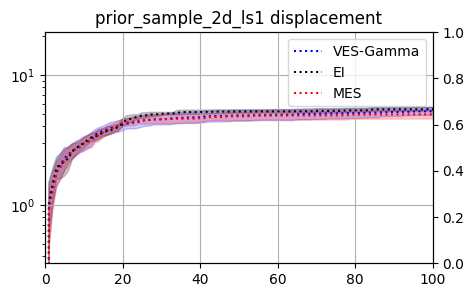

prior_sample_2d_ls2


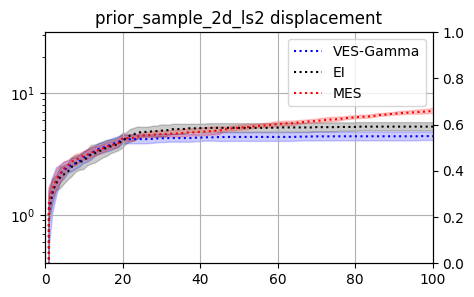

prior_sample_50d_ls0.5


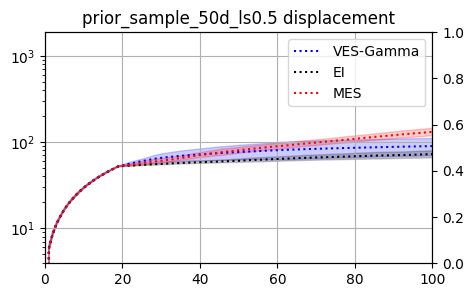

prior_sample_50d_ls1


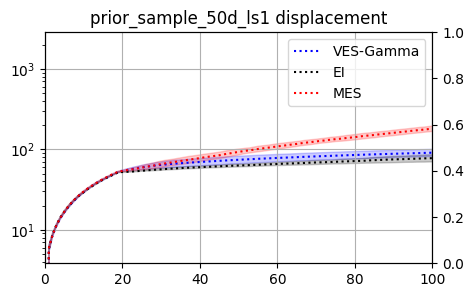

prior_sample_50d_ls2


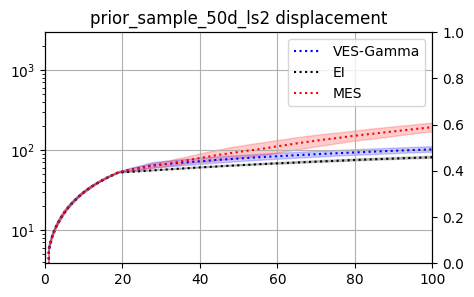

prior_sample_100d_ls0.5


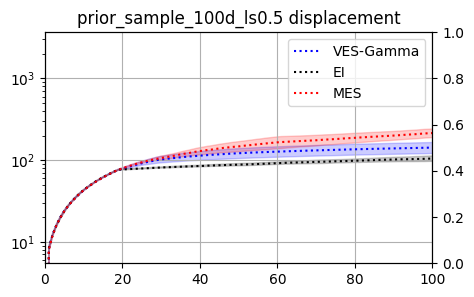

prior_sample_100d_ls1


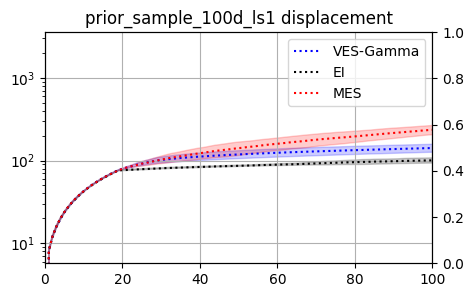

prior_sample_100d_ls2


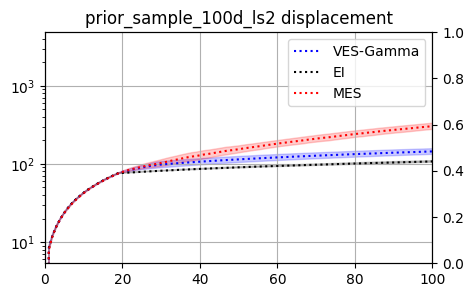

levy300


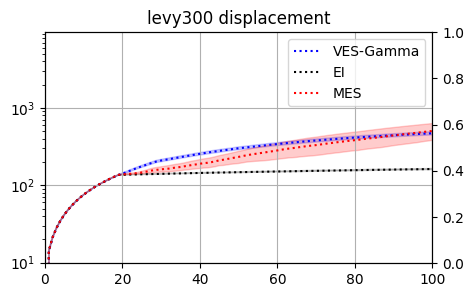

levy500


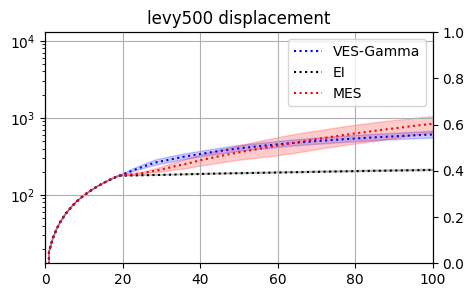

schwefel300


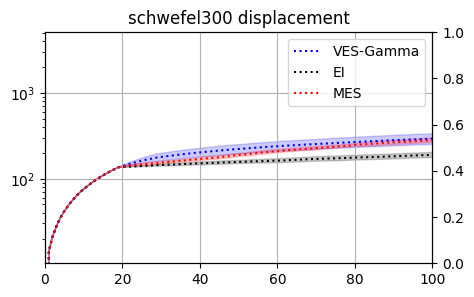

schwefel500


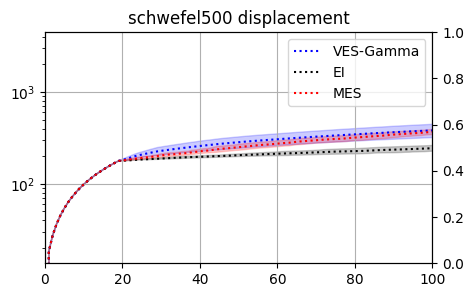

griewank300


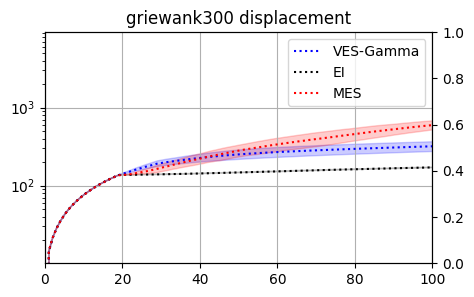

griewank500


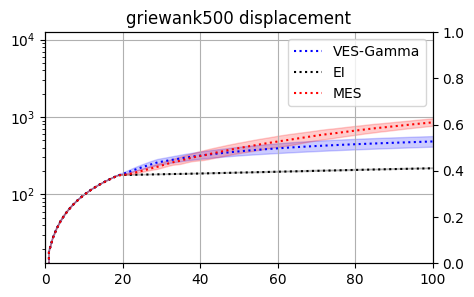

lasso-high


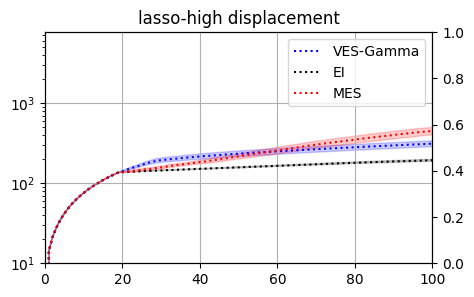

lasso-hard


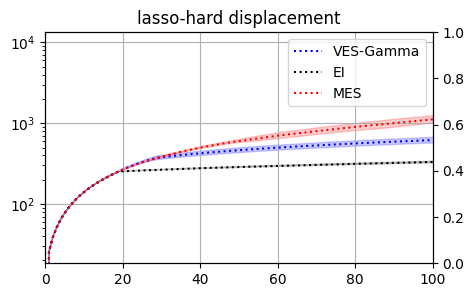

lasso-dna


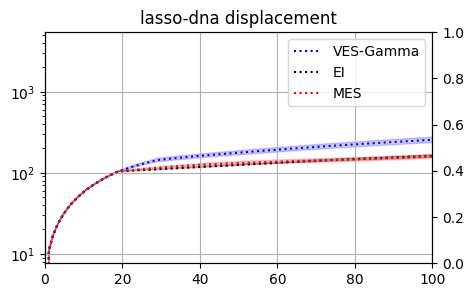

svm


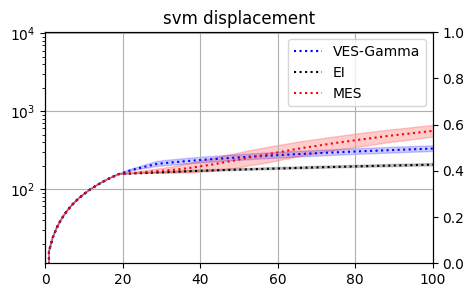

In [13]:
NUM_PATHS = 256
from multiprocessing import Pool
pool = Pool()

for disp in [True]:
    for benchmark in benchmarks:
        print(benchmark)
        
        def general_dir_match(
                args: dict,
        ):
            if not 'prior_sample' in benchmark:
                return True
            else:
                ls = float(benchmark.split('_')[-1][2:])
                set_ls = args['set_lengthscale'] 
                return set_ls is None
        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
        relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]
        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]
        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
        
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.grid()

        ves_x = [np.load(f'{d}/train_x_ves.npy') for d in ves_dirs]
        if len(ves_x) == 0:
            print('VES missing')
        else:
            min_len = max(100,min([len(x) for x in ves_x]))
            if disp:
                x_list = [x[:min_len] for x in ves_x]
                exp_x_disp = pool.map(exploration_tsp, x_list)
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ves_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='VES-Gamma', color='blue', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='blue')
            
        ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
        if len(ei_x) == 0:
            print('EI missing')
        else:
            min_len = max(100,min([len(x) for x in ei_x]))
            if disp:
                x_list = [x[:min_len] for x in ei_x]
                exp_x_disp = pool.map(exploration_tsp, x_list)
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ei_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='EI', color='black', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='black')
        
        mes_x = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
        if len(mes_x) == 0:
            print('MES missing')
        else:
            min_len = max(100,min([len(x) for x in mes_x]))
            if disp:
                x_list = [x[:min_len] for x in mes_x]
                exp_x_disp = pool.map(exploration_tsp, x_list)
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in mes_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='MES', color='red', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='red')
        
        ax.legend()
        ax.set_title(f'{benchmark} displacement' if disp else f'{benchmark} entropy')
        ax.set_xlim(0, 100)
        ax.set_yscale('log')
    
        plt.show()

### Test Functions

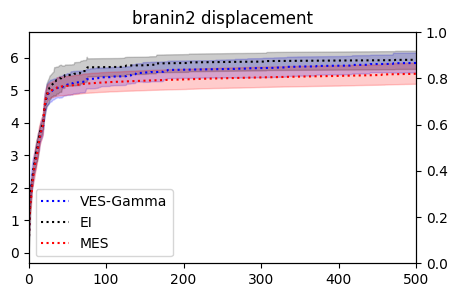

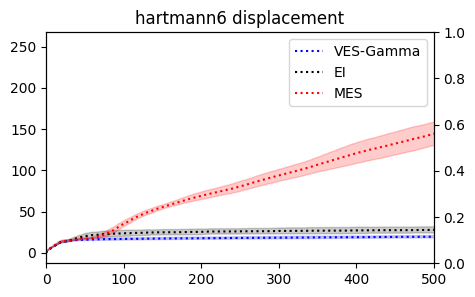

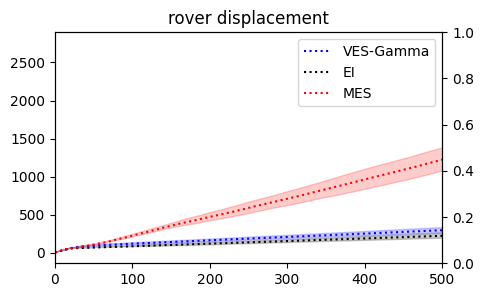

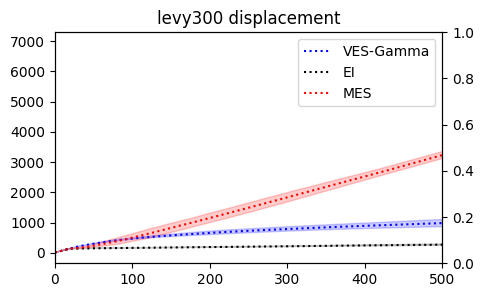

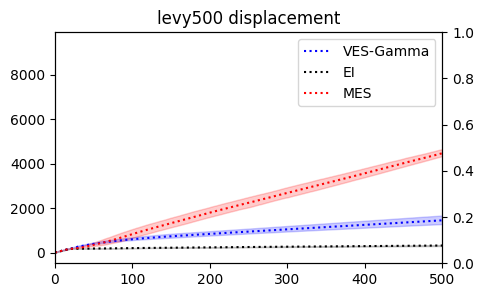

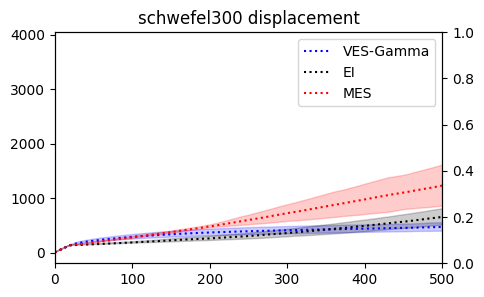

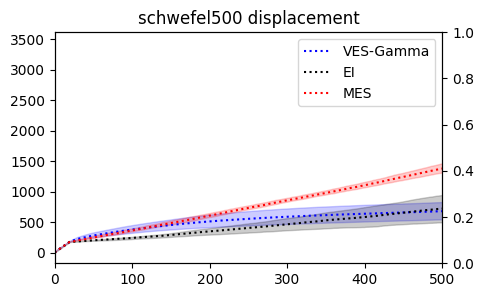

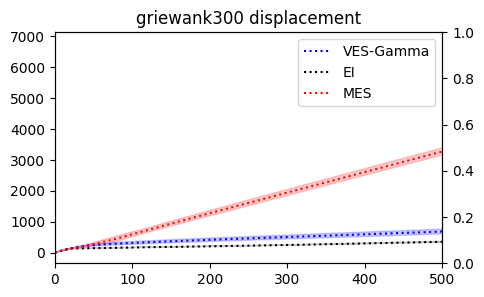

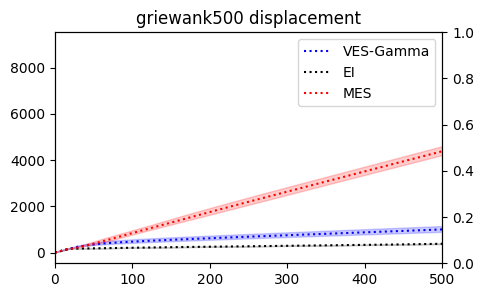

In [ ]:
test_benchmarks = ['branin2','hartmann6', 'rover', 'levy300', 'levy500', 'schwefel300', 'schwefel500', 'griewank300', 'griewank500']

for disp in [True, False]:
    for benchmark in test_benchmarks:

        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]
        
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.grid()

        ves_x = [np.load(f'{d}/train_x_ves.npy') for d in ves_dirs]
        if len(ves_x) == 0:
            print('VES missing')
        else:
            min_len = min([len(x) for x in ves_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in ves_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ves_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='VES-Gamma', color='blue', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='blue')
            
        ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
        if len(ei_x) == 0:
            print('EI missing')
        else:
            min_len = min([len(x) for x in ei_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in ei_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ei_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='EI', color='black', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='black')
        
        mes_x = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
        if len(mes_x) == 0:
            print('MES missing')
        else:
            min_len = min([len(x) for x in mes_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in mes_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in mes_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='MES', color='red', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='red')

        ax.legend()
        ax.grid()
        ax.set_title(f'{benchmark} displacement' if disp else f'{benchmark} entropy')
        ax.set_xlim(0, 500)
    
    plt.show()

### Real-world Benchmarks 

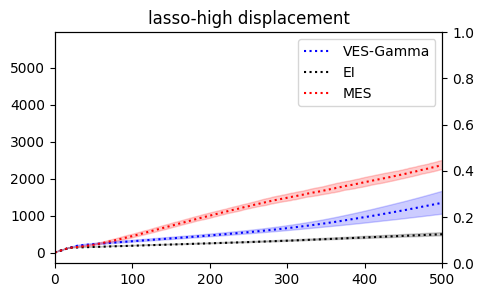

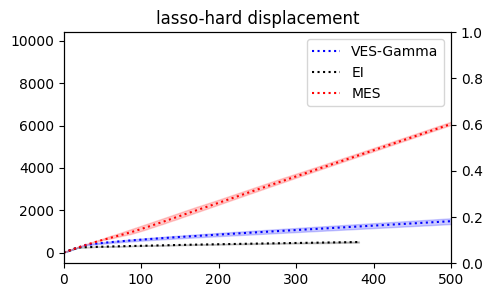

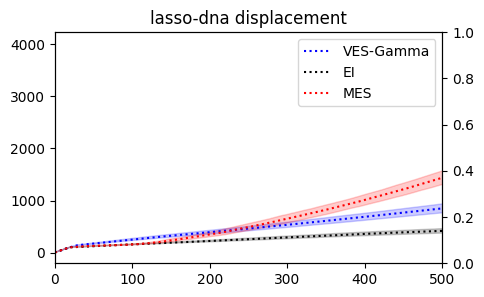

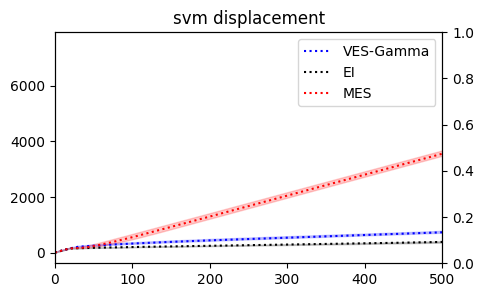

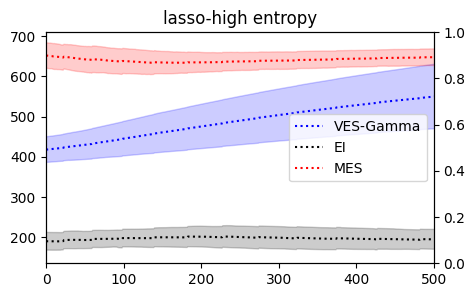

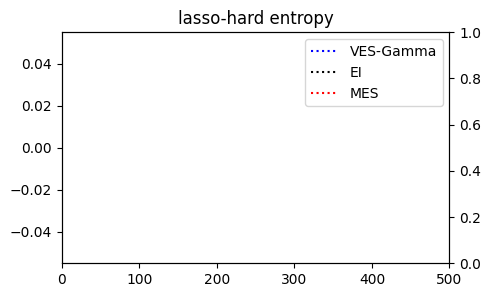

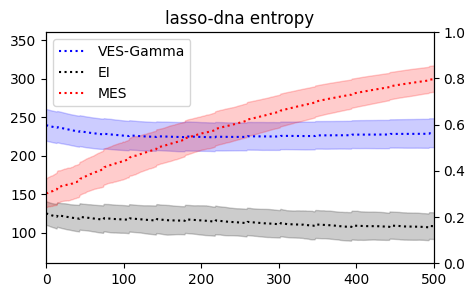

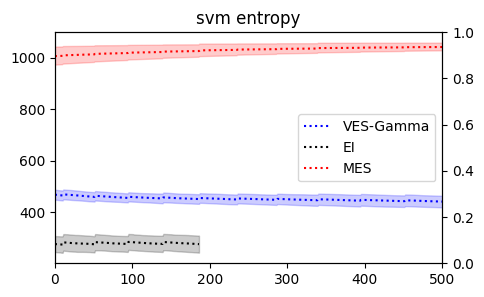

In [29]:
real_benchmarks = ['lasso-high', 'lasso-hard', 'lasso-dna', 'svm']
names = {
    'lasso-high': 'Lasso High',
    'lasso-hard': 'Lasso Hard',
    'lasso-dna': 'Lasso DNA 180D',
    'svm': 'SVM 388D'
}

for disp in [True, False]:
    for benchmark in real_benchmarks:
        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]

        fig, ax = plt.subplots(figsize=(5, 3))
        ax.grid()

        ves_x = [np.load(f'{d}/train_x_ves.npy') for d in ves_dirs]
        if len(ves_x) == 0:
            print('VES missing')
        else:
            min_len = min([len(x) for x in ves_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in ves_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ves_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='VES-Gamma', color='blue', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='blue')
            
        ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
        if len(ei_x) == 0:
            print('EI missing')
        else:
            min_len = min([len(x) for x in ei_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in ei_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in ei_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='EI', color='black', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='black')
        
        mes_x = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
        if len(mes_x) == 0:
            print('MES missing')
        else:
            min_len = min([len(x) for x in mes_x])
            if disp:
                exp_x_disp = [exploration_tsp(x[:min_len]) for x in mes_x]
                exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
                exp_mean = np.mean(exp_x_disp, axis=0)
                exp_std = np.std(exp_x_disp, axis=0)
            else:
                exp_x_entp = [exploration_entropy(x[:min_len]) for x in mes_x]
                exp_x_entp = np.stack(exp_x_entp)
                exp_mean = np.mean(exp_x_entp, axis=0)
                exp_std = np.std(exp_x_entp, axis=0)
            
            ax.plot(exp_mean, label='MES', color='red', linestyle=':')
            ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='red')
        
        ax.legend()
        ax.grid()
        ax.set_title(f'{benchmark} displacement' if disp else f'{benchmark} entropy')
        ax.set_xlim(0, 500)
    plt.show()

### High-dimensional Prior Tests

ValueError: min() arg is an empty sequence

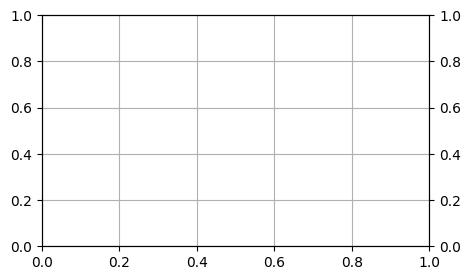

In [30]:
benchmarks = ['branin2','rover', 'mopta08', 'lasso-dna', 'svm']
names = {
    'branin2': 'Branin 2D',
    'rover': 'Rover',
    'mopta08': 'Mopta08',
    'lasso-dna': 'Lasso DNA 180D',
    'svm': 'SVM 388D'
}

run_dirs = glob.glob('results/ves_vbo_prior/*')

for disp in [True, False]:
    for benchmark in benchmarks:
        
        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

        ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
        mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
        ves_dirs = [d for d in relevant_dirs if f'{d}/train_x_ves.npy' in glob.glob(f'{d}/*')]


        fig, ax = plt.subplots(figsize=(5, 3))
        ax.grid()
        ax2 = ax.twinx()

        ves_x = [np.load(f'{d}/train_x_ves.npy') for d in ves_dirs]
        min_len = min([len(x) for x in ves_x])
        if disp:
            exp_x_disp = [exploration_tsp(x[:min_len]) for x in ves_x]booksbooks
            exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
            exp_mean = np.mean(exp_x_disp, axis=0)
            exp_std = np.std(exp_x_disp, axis=0)books
        else:
            exp_x_entp = [exploration_entropy(x[:min_len]) for x in ves_x]
            exp_x_entp = np.stack(exp_x_entp)
            exp_mean = np.mean(exp_x_entp, axis=0)
            exp_std = np.std(exp_x_entp, axis=0)
        
        ax.plot(exp_mean, label='VES-Gamma', color='blue', linestyle=':')
        ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='blue')
        
        ei_x = [np.load(f'{d}/train_x_ei.npy') for d in ei_dirs]
        min_len = min([len(x) for x in ei_x])
        if disp:
            exp_x_disp = [exploration_tsp(x[:min_len]) for x in ei_x]
            exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
            exp_mean = np.mean(exp_x_disp, axis=0)
            exp_std = np.std(exp_x_disp, axis=0)
        else:
            exp_x_entp = [exploration_entropy(x[:min_len]) for x in ei_x]
            exp_x_entp = np.stack(exp_x_entp)
            exp_mean = np.mean(exp_x_entp, axis=0)
            exp_std = np.std(exp_x_entp, axis=0)
        
        ax.plot(exp_mean, label='EI', color='black', linestyle=':')
        ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='black')
        
        mes_y = [np.load(f'{d}/train_x_mes.npy') for d in mes_dirs]
        min_len = min([len(x) for x in mes_x])
        if disp:books
            exp_x_disp = [exploration_tsp(x[:min_len]) for x in mes_x]
            exp_x_disp = np.stack(exp_x_disp).squeeze(-1)
            exp_mean = np.mean(exp_x_disp, axis=0)
            exp_std = np.std(exp_x_disp, axis=0)
        else:
            exp_x_entp = [exploration_entropy(x[:min_len]) for x in mes_x]
            exp_x_entp = np.stack(exp_x_entp)
            exp_mean = np.mean(exp_x_entp, axis=0)
            exp_std = np.std(exp_x_entp, axis=0)
        
        ax.plot(exp_mean, label='MES', color='red', linestyle=':')
        ax.fill_between(np.arange(len(exp_mean)), exp_mean-exp_std, exp_mean+exp_std, alpha=0.2, color='red')
    
        ax.legend()
        ax.grid()
        ax.set_title(names[f'{benchmark}']+' displacement' if disp else names[f'{benchmark}']+' entropy')

plt.show()
    
    